Data:

* **esea_master_grenades_demos.part1.csv, esea_master_grenades_demos.part2.csv**
  * 2990060 rows, 2256398 rows
  * 'file', 'round', 'seconds', 'att_team', 'vic_team', 'att_id', 'vic_id',
       'att_side', 'vic_side', 'hp_dmg', 'arm_dmg', 'hitbox', 'nade', 'att_rank', 'vic_rank', 'att_pos_x',
       'att_pos_y', 'nade_land_x', 'nade_land_y', 'vic_pos_x', 'vic_pos_y'
  * 'att_team', 'vic_team': the team throwing and getting hit by the grenade, respectively
  * 'is_bomb_planted', 'bomb_site': Whether the bomb has been planted, and if so, at which site
       
* **esea_meta_demos.part1.csv, esea_meta_demos.part2.csv**
  * 215919 rows, 161710 rows
  * ['file', 'map', 'round', 'start_seconds', 'end_seconds', 'winner_team',
       'winner_side', 'round_type', 'ct_eq_val', 't_eq_val']
* **esea_master_kills_demos.part1.csv, esea_master_kills_demos.part2.csv**
  * 1569477 rows, 1173169 rows
  * ['file', 'round', 'tick', 'seconds', 'att_team', 'vic_team', 'att_side',
       'vic_side', 'wp', 'wp_type', 'ct_alive', 't_alive', 'is_bomb_planted']
* **esea_master_dmg_demos.part1.csv, esea_master_dmg_demos.part2.csv**
  * 5992097 rows, 4546085 rows
  * ['file', 'map', 'round', 'start_seconds', 'end_seconds', 'winner_team',
       'winner_side', 'round_type']
  * 'ct_eq_val', 't_eq_val': Team equipment value
* **mm_grenades_demos.csv**
  * 366098 rows
  * ['Unnamed: 0', 'file', 'map', 'round', 'start_seconds', 'seconds',
       'end_seconds', 'att_team', 'vic_team', 'att_id', 'vic_id', 'att_side',
       'vic_side', 'hp_dmg', 'arm_dmg', 'is_bomb_planted', 'bomb_site',
       'hitbox', 'nade', 'winner_team', 'winner_side', 'att_rank', 'vic_rank',
       'att_pos_x', 'att_pos_y', 'nade_land_x', 'nade_land_y', 'vic_pos_x',
       'vic_pos_y', 'round_type', 'ct_eq_val', 't_eq_val', 'avg_match_rank']
* **mm_master_demos.csv**
  * 955466 rows
  * ['Unnamed: 0', 'file', 'map', 'date', 'round', 'tick', 'seconds',
       'att_team', 'vic_team', 'att_side', 'vic_side', 'hp_dmg', 'arm_dmg',
       'is_bomb_planted', 'bomb_site', 'hitbox', 'wp', 'wp_type', 'award',
       'winner_team', 'winner_side', 'att_id', 'att_rank', 'vic_id',
       'vic_rank', 'att_pos_x', 'att_pos_y', 'vic_pos_x', 'vic_pos_y',
       'round_type', 'ct_eq_val', 't_eq_val', 'avg_match_rank']
* **map_data.csv**
  * ['Unnamed: 0', 'EndX', 'EndY', 'ResX', 'ResY', 'StartX', 'StartY']



**Counter Strike: Global Offensive Utility Analysis**
Counter Strike: Global Offensive is a team-based strategic shooter where one team, the terrorists, tries to plant a bomb and defend it until it detonates while the other team, the counter terrorists, attempt to stop the bomb plant or defuse it once it's planted. One thing that has always drawn me to this game is the importance of *utility* — smoke grenades, flashbangs, and hand grenades. A well-thrown smoke can give your team cover to advance into a new position or block eyesight from an enemy and can have a pivotal role on the round.

This dataset contains all types of utility thrown during thousands of competitive games (containing millions of grenades) as well as other datapoints such as if/when the bomb was planted, and who won. Naturally, I had questions about how utility actually impacts gameplay.

Questions:
1. Which positions are effective smoke positions for round wins, on either side? 
    a. Which smokes and flashes thrown by terrorists before the bomb is planted result in a bomb plant? Which smokes thrown by CTs after a bomb plant result in a defusal? 
    b. What grenades in general are effective in winning the round? To study this, we can use regression to calculate the marginal impact of each grenade.
    c. What groups of smokes are most effective?
2. Which nade positions do the most damage on average/nade damage heatmap
4. Do any of these conclusions change based on round type?
 

In [1]:
import numpy as np 
import pandas as pd 
import matplotlib.pyplot as plt
import seaborn as sns
import gc
import math
import pandas_profiling

In [2]:
grenade_df = pd.read_csv('/kaggle/input/csgo-matchmaking-damage/esea_master_grenades_demos.part1.csv')
grenade_df = grenade_df[['file', 'round', 'seconds', 'att_side', 'vic_side', 'is_bomb_planted', 'bomb_site', 'nade', 'nade_land_x', 'nade_land_y']]
meta_df = pd.read_csv('/kaggle/input/csgo-matchmaking-damage/esea_meta_demos.part1.csv')
grenade_df = pd.merge(grenade_df, meta_df, how='left', left_on=['file','round'], right_on = ['file','round'])
grenade_df['seconds'] -= grenade_df['start_seconds']

grenade_df.set_index(['file', 'round'], inplace=True)

map_df = pd.read_csv('/kaggle/input/csgo-matchmaking-damage/map_data.csv')
map_df = map_df.rename( columns={'Unnamed: 0':'map_name'}).set_index('map_name')
print(map_df)

print(grenade_df.info())
print(grenade_df.head())


             EndX  EndY  ResX  ResY  StartX  StartY
map_name                                           
de_cache     3752  3187  1024  1024   -2031   -2240
de_cbble     2282  3032  1024  1024   -3819   -3073
de_dust2     2127  3455  1024  1024   -2486   -1150
de_inferno   2797  3800  1024  1024   -1960   -1062
de_mirage    1912  1682  1024  1024   -3217   -3401
de_overpass   503  1740  1024  1024   -4820   -3591
de_train     2262  2447  1024  1024   -2436   -2469
<class 'pandas.core.frame.DataFrame'>
MultiIndex: 2990060 entries, (esea_match_13770997.dem, 1) to (esea_match_13793043.dem, 18)
Data columns (total 16 columns):
seconds            float64
att_side           object
vic_side           object
is_bomb_planted    bool
bomb_site          object
nade               object
nade_land_x        float64
nade_land_y        float64
map                object
start_seconds      float64
end_seconds        float64
winner_team        object
winner_side        object
round_type         object
ct_

In [3]:
from sklearn.cluster import AgglomerativeClustering, DBSCAN
from sklearn.neighbors.nearest_centroid import NearestCentroid
from time import time
from sklearn.linear_model import LogisticRegression

#Convert map coordinates to image coordinates, from Bill Freeman's analysis
def pointx_to_resolutionx(xinput,startX=-3217,endX=1912,resX=1024):
    sizeX = endX - startX
    if startX < 0:
        xinput += startX * (-1.0)
    else:
        xinput += startX
    xoutput = float((xinput / abs(sizeX)) * resX);
    return xoutput

def pointy_to_resolutiony(yinput,startY=-3401,endY=1682,resY=1024):
    sizeY=endY-startY
    if startY < 0:
        yinput += startY *(-1.0)
    else:
        yinput += startY
    youtput = float((yinput / abs(sizeY)) * resY);
    return resY-youtput

#grenade_df['att_pos_x'] = grenade_df['att_pos_x'].apply(pointx_to_resolutionx)
#grenade_df['att_pos_y'] = grenade_df['att_pos_y'].apply(pointy_to_resolutiony)

def cluster_utility(grenade_df, max_nades_to_process=-1, nade_types = ['Smoke', 'HE', 'Flash'], teams = ['Terrorist', 'CounterTerrorist'], map_name='de_mirage'):
    """
    Given a dataframe of grenade usage, clusters the grenades into the most common spots, and plots the results.
    """
    # Create graphics
    fig, axs = plt.subplots(len(nade_types), len(teams), figsize=(25,25))
    map_filenames = {map_name: f'/kaggle/input/csgo-matchmaking-damage/{map_name}.png' for map_name in grenade_df['map'].unique()}
    im = plt.imread(map_filenames[map_name])
    
    # Preprocess data on map of interest
    t_mirage_df = grenade_df[grenade_df['map'] == map_name]
    map_info = map_df.loc[map_name]
    t_mirage_df['cluster'] = None

    
    # For each nade type and team, we will compute clusters and create a plot
    for i, nade_type in enumerate(nade_types):
        for j, team in enumerate(teams):
            before_time = time()
            t_mirage_nade_df = t_mirage_df[(t_mirage_df.nade==nade_type) & (t_mirage_df.att_side==team)]
            # Correct location
            t_mirage_nade_df['nade_land_y'] = t_mirage_nade_df['nade_land_y'].apply(pointy_to_resolutiony, args=(map_info['StartY'], map_info['EndY'], map_info['ResY']))
            t_mirage_nade_df['nade_land_x'] = t_mirage_nade_df['nade_land_x'].apply(pointx_to_resolutionx, args=(map_info['StartX'], map_info['EndX'], map_info['ResX']))
            # Determine how many points we will use from the data
            available_datapoints = len(t_mirage_nade_df)
            num_nades = max_nades_to_process
            if max_nades_to_process < 0:
                num_nades = available_datapoints
            num_nades = min(num_nades, available_datapoints)
            print(f"Using {num_nades}/{available_datapoints} available datapoints in {team} {nade_type}")
            t_mirage_nade_df = t_mirage_nade_df[:num_nades]
            ### Cluster into common smoke positions
            cluster = DBSCAN(eps=8, min_samples=num_nades/350, metric='euclidean', metric_params=None, algorithm='auto', leaf_size=30, p=None, n_jobs=None)
            smoke_pts = pd.concat([t_mirage_nade_df['nade_land_x'], t_mirage_nade_df['nade_land_y']], axis=1)
            cluster.fit(smoke_pts)
            t_mirage_nade_df['cluster'] = cluster.labels_
            ### Find centroids of clusters
            centroids = NearestCentroid()
            centroids.fit(smoke_pts, cluster.labels_)
            nade_clusters = centroids.centroids_
            
            # Calculate distance to centroid
            def distance_to_centroid(row):
                if row['cluster'] == -1:
                    return np.nan
                centroid = nade_clusters[row['cluster']+1]
                return math.sqrt((row['nade_land_x'] - centroid[0]) ** 2 + (row['nade_land_y'] - centroid[1]) ** 2)
            #t_mirage_nade_df['distance_to_centroid'] = t_mirage_nade_df.apply(distance_to_centroid, axis=1)
            
            # Plot smokes and clusters
            axs[i, j].set_title(f"{map_name} {team} {nade_type}s")
            axs[i, j].set_xlim(0, 1000)
            axs[i, j].set_ylim(1000, 0)
            t = axs[i, j].imshow(im)
            # Create map from clusters to color pallete
            color_labels = np.unique(cluster.labels_)
            rgb_values = sns.color_palette("Set2", color_labels.shape[0])
            color_map = dict(zip(color_labels, rgb_values))
            color_map[-1] = (0, 0, 0)

            # Plot! Uncomment one of the following to plot clusters, distance to centroid, or winning side
            #axs[i, j].scatter(t_mirage_nade_df['nade_land_x'], t_mirage_nade_df['nade_land_y'],alpha=2500/num_nades,c=t_mirage_nade_df['cluster'].map(color_map), marker='.')
            #axs[i, j].scatter(t_mirage_nade_df['nade_land_x'], t_mirage_nade_df['nade_land_y'],alpha=2500/num_nades,c=t_mirage_nade_df['distance_to_centroid'], marker='.', cmap=plt.cm.autumn)
            axs[i, j].scatter(t_mirage_nade_df['nade_land_x'], t_mirage_nade_df['nade_land_y'],alpha=2500/num_nades,c=(t_mirage_nade_df['winner_side'] == team).map({True: (1, 0, 0), False: (0, 0, 1)}), marker='.', cmap=plt.get_cmap('plasma'))
            
            axs[i, j].scatter(nade_clusters[:, 0], nade_clusters[:, 1], alpha=1,c='yellow')
            for k, pos in enumerate(zip(nade_clusters[:, 0], nade_clusters[:, 1])):
                print(f"{k}: {pos}")
                axs[i, j].annotate(str(k), pos, color='white', fontsize=15)

            # Collect our results
            t_mirage_df = t_mirage_df[(t_mirage_df.nade!=nade_type) | (t_mirage_df.att_side!=team)]
            t_mirage_df = t_mirage_df.append(t_mirage_nade_df)
            elapsed_time = time() - before_time
            print(f"Clustering took {elapsed_time} seconds")
            # Save the data
            n_points = 10000
            print(t_mirage_nade_df.columns)
            t_mirage_nade_df = t_mirage_nade_df.reset_index()
            t_mirage_nade_df["file_round"] = t_mirage_nade_df["file"] + t_mirage_nade_df["round"].astype(str)
            t_mirage_nade_df = t_mirage_nade_df[['file_round', 'seconds', 'att_side', 'bomb_site', 'nade_land_x', 'nade_land_y', 'cluster', 'winner_side']]
            t_mirage_nade_df.sample(n_points).to_csv(f'{map_name}_{team}_{nade_type}_{n_points}_locs.csv')
    print( t_mirage_df.loc[("esea_match_13792436.dem", 10)])
    t_mirage_df.loc[("esea_match_13792436.dem", 10)].to_csv(f'{map_name}_example_round.csv')
    return t_mirage_df

Calculating for de_mirage...


/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:49: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:50: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/

Using 130000/143336 available datapoints in Terrorist Smoke
0: (452.55279916627654, 477.6194220963944)
1: (412.3231784885512, 465.109129836526)
2: (594.1309915485532, 437.6918989324915)
3: (461.7446484043984, 821.1166262502038)
4: (509.00972940876113, 668.6880542583147)
5: (551.5839064880262, 662.5467463955367)
6: (481.41428784157847, 369.43871379667075)
7: (508.19803730152006, 436.0586032773428)
8: (465.44476478866534, 638.3168000415682)
9: (503.6944608264807, 466.41309886330686)
10: (584.0902289477892, 665.6219543857977)
11: (642.772567491107, 757.5021389333315)
12: (177.46685215119396, 236.93458637838805)
13: (642.2710079937398, 338.84871139089825)
14: (510.8662465236831, 549.3958484285664)
15: (641.3267447729592, 426.7585432895477)
16: (237.604103981123, 188.7281792382608)
17: (509.1894993540615, 599.258935223704)
18: (641.4199199024735, 665.5518772378524)
19: (510.55504584974295, 521.1190972483319)
20: (553.7043733269966, 754.2903196283988)
21: (256.53991961966744, 386.69106183040

/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:49: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:50: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


Using 128548/128548 available datapoints in CounterTerrorist Smoke
0: (496.59273586330363, 493.63755088166147)
1: (691.0539655865222, 645.2833471621517)
2: (348.2511902121882, 190.29960220563697)
3: (654.6647431038873, 797.0953337242231)
4: (512.6454782422155, 504.92433039377806)
5: (530.7134174427798, 425.7424294885216)
6: (509.0759556491935, 590.3348729174228)
7: (421.8447432300754, 465.466006939742)
8: (642.2710079937648, 338.8487113909131)
9: (742.3300032645998, 672.5742163702647)
10: (446.7759007082295, 432.7104551982764)
Clustering took 14.97860836982727 seconds
Index(['seconds', 'att_side', 'vic_side', 'is_bomb_planted', 'bomb_site',
       'nade', 'nade_land_x', 'nade_land_y', 'map', 'start_seconds',
       'end_seconds', 'winner_team', 'winner_side', 'round_type', 'ct_eq_val',
       't_eq_val', 'cluster'],
      dtype='object')


/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:49: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:50: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


Using 74955/74955 available datapoints in Terrorist HE
0: (461.00129069603395, 532.5496767806679)
1: (442.0497721919937, 281.01331277030863)
2: (510.9041080128, 519.6885451158295)
3: (472.37058649020014, 381.78992595039654)
4: (417.38114347321897, 473.4019323541939)
5: (642.2710079937619, 338.8487113909109)
6: (477.6443132224713, 640.288198063267)
7: (397.25893211189924, 591.4853249925628)
8: (185.0955709646097, 183.6738739403725)
9: (481.3605540902369, 313.1865129729)
10: (663.075083469522, 740.9985727321795)
11: (496.8590191166635, 578.8955751813908)
12: (434.94212019254564, 838.442302360393)
13: (485.89925296551075, 530.9746552105518)
14: (718.0536459376896, 652.4686177105481)
15: (239.2927522090081, 183.96847565469525)
16: (490.49112802201785, 682.9333172107251)
17: (326.6740649569917, 226.4337853682259)
18: (647.6984017041863, 662.200372706384)
19: (106.11248737857389, 180.61256697411213)
20: (416.05840103320907, 533.9939130719982)
21: (238.46475914942857, 465.53278578662355)
22: 

/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:49: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:50: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


Using 123203/123203 available datapoints in CounterTerrorist HE
0: (517.5052244653828, 492.15147778480195)
1: (720.8737467590578, 652.2910598593638)
2: (385.53170318661347, 190.55702323170655)
3: (692.7083355194744, 400.2426698206759)
4: (668.6776984578764, 805.2499391200839)
5: (447.03537618335787, 439.3876595786627)
6: (733.2053750852184, 475.1820466106736)
Clustering took 9.382046222686768 seconds
Index(['seconds', 'att_side', 'vic_side', 'is_bomb_planted', 'bomb_site',
       'nade', 'nade_land_x', 'nade_land_y', 'map', 'start_seconds',
       'end_seconds', 'winner_team', 'winner_side', 'round_type', 'ct_eq_val',
       't_eq_val', 'cluster'],
      dtype='object')


/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:49: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:50: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


Using 130000/153212 available datapoints in Terrorist Flash
0: (528.1908125805332, 503.65882711869585)
1: (439.67645082432307, 270.14652862156606)
2: (638.7917345116607, 668.5433731501074)
3: (466.3316034161215, 643.0274979816953)
4: (297.17543859570185, 236.29947942992416)
5: (486.32250058024647, 358.2954536306548)
6: (665.7944895478054, 443.1328851231138)
7: (656.6928303335617, 762.9790593856898)
8: (465.4464480542397, 393.3919674591965)
9: (642.273417086876, 338.9105359363992)
10: (696.2406013711811, 503.8087237273283)
11: (509.05509908364274, 512.6415215084338)
Clustering took 6.493006706237793 seconds
Index(['seconds', 'att_side', 'vic_side', 'is_bomb_planted', 'bomb_site',
       'nade', 'nade_land_x', 'nade_land_y', 'map', 'start_seconds',
       'end_seconds', 'winner_team', 'winner_side', 'round_type', 'ct_eq_val',
       't_eq_val', 'cluster'],
      dtype='object')


/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:49: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:50: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


Using 111562/111562 available datapoints in CounterTerrorist Flash
0: (514.10121629923, 537.7663192565481)
1: (664.1082739872661, 807.4967991718786)
2: (477.6856353260188, 466.9638949541844)
3: (705.099937212142, 652.8936693745029)
4: (648.1784588652173, 701.7579341992686)
5: (321.88211881858547, 186.86847455522107)
6: (440.4323083682988, 253.90863636744746)
7: (642.2189539310565, 338.86138010362185)
8: (428.2303983653358, 199.7081926722787)
9: (538.3402893517518, 669.2455148066352)
10: (623.7682424225113, 735.1340378535589)
Clustering took 5.168915748596191 seconds
Index(['seconds', 'att_side', 'vic_side', 'is_bomb_planted', 'bomb_site',
       'nade', 'nade_land_x', 'nade_land_y', 'map', 'start_seconds',
       'end_seconds', 'winner_team', 'winner_side', 'round_type', 'ct_eq_val',
       't_eq_val', 'cluster'],
      dtype='object')


/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:110: PerformanceWarning: indexing past lexsort depth may impact performance.
/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:111: PerformanceWarning: indexing past lexsort depth may impact performance.


                               seconds          att_side vic_side  \
file                    round                                       
esea_match_13792436.dem 10     19.0020  CounterTerrorist      NaN   
                        10     19.4559  CounterTerrorist      NaN   
                        10     23.4159  CounterTerrorist      NaN   
                        10     23.7290  CounterTerrorist      NaN   
                        10     21.8037  CounterTerrorist      NaN   
                        10     46.8006  CounterTerrorist      NaN   
                        10     27.4699  CounterTerrorist      NaN   

                               is_bomb_planted bomb_site        nade  \
file                    round                                          
esea_match_13792436.dem 10               False       NaN  Incendiary   
                        10               False       NaN  Incendiary   
                        10               False       NaN       Smoke   
                  

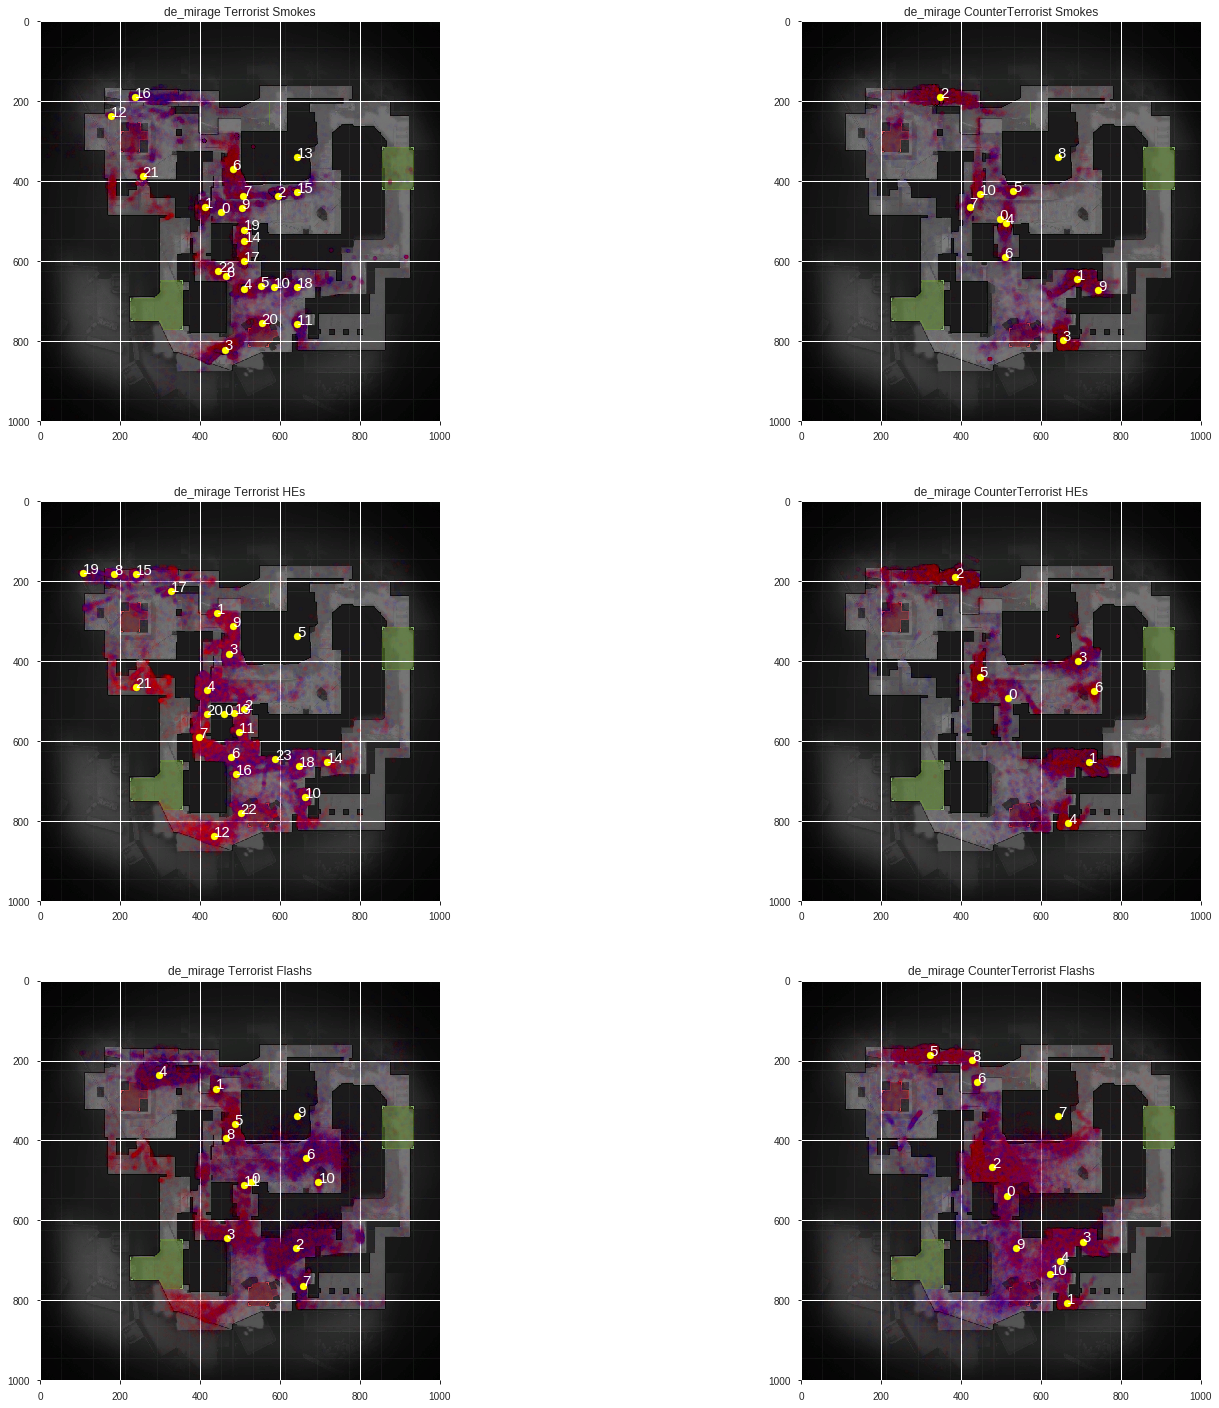

In [4]:
for map_name in ['de_mirage']:#['de_cache', 'de_cbble', 'de_dust2', 'de_inferno', 'de_mirage', 'de_overpass', 'de_train']:
    print(f"Calculating for {map_name}...")
    
    clustered_nade_df = cluster_utility(grenade_df, map_name=map_name, max_nades_to_process = 130000)
    perc_unclustered = 100 * len(clustered_nade_df[clustered_nade_df['cluster'] == -1]) / len(clustered_nade_df)
    print(f"{perc_unclustered}% of nades are unclustered")

    print(clustered_nade_df.columns)
    round_nade_df = pd.get_dummies(data=clustered_nade_df, columns=['cluster'])
    cluster_cols = [col for col in round_nade_df if col.startswith('cluster')]
    #print(t_mirage_df_one_hot[['att_side', 'nade'] + cols])
    round_nade_df = round_nade_df.drop(['round_type', 'winner_side'], axis=1).groupby(['file', 'round', 'att_side', 'nade'])
    round_nade_df = round_nade_df[cluster_cols].sum()
    round_nade_df = round_nade_df.unstack(level=['att_side', 'nade'])
    round_nade_df.columns = round_nade_df.columns.to_flat_index()
    round_nade_df = round_nade_df.reset_index()
    # Combine round win information
    meta_df = pd.read_csv('/kaggle/input/csgo-matchmaking-damage/esea_meta_demos.part1.csv')[['file', 'round', 'winner_side']]
    round_nade_df = pd.merge(round_nade_df, meta_df, how='left', left_on=['file','round'], right_on = ['file','round'])
    round_nade_df = round_nade_df.fillna(0)
    round_nade_df.columns = [tup if isinstance(tup, str) else f"{tup[2]}_{tup[1]}_{tup[0]}" for tup in round_nade_df.columns]
    # Remove clusters with no nades
    nade_counts = round_nade_df.drop(['file', 'round', 'winner_side'], axis=1).sum(axis=0)
    round_nade_df = round_nade_df.drop(nade_counts[nade_counts == 0].keys(), axis=1)
    round_nade_df.to_csv(f'{map_name}_clustered_nade_round_win.csv')
    gc.collect()
